## Global settings

In [1]:
# The code has been modified to support multiple GPU:s, while the paper only used a single GPU.
# Due to the random nature of neural networks, the results may differ slightly from from what was 
# presented in the paper (these results are slightly better).

# Path to images folder: should have three sub directories: train, valid, and test
# Each of the three folders should have a subdirectory for each of the eight classes, 1-8, containing image files.
# The image filenames should be on the format: embryo-identifier_focal.jpg, where embryo-identifier
# is unique for each embryo and focal identifies the focal plane (-45, -30, -15, 0, 15, 30, or 45).
path = 'C:/Research/Jonas/Jonas8MF/'

tensorboard_dir = 'C:/Users/Jonas/tensorboard'

# Name of notebook is used to store model parameters after training.
# Parameters can then be loaded into the model without repeating training.
notebook = 'MalmstenEmbryoNetNotebook'

# Resize images before training, smaller size uses less memory but may not provide as good predictions
image_size = 225

# Batch size, how many images that will be used in each training batch
batch_size = 64

# List of focal planes to include in training. Only images which have all focal planes will be used.
focals = [-45, -30, -15, 0, 15, 30, 45]

# Only 3 focals can be visualized in one RGB image
disp_min = len(focals) // 2-1
disp_max = len(focals) // 2+2


## Import Libraries

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import ImageFile

# Images from the instrument are sometimes truncated (missing jpeg end-of-stream tag)
ImageFile.LOAD_TRUNCATED_IMAGES = True

import tensorflow as tf
from keras import backend as K

#config = tf.ConfigProto()
#config.gpu_options.allow_growth=True
#config.allow_soft_placement=True
#config.gpu_options.per_process_gpu_memory_fraction = 0.95
#config.log_device_placement=True
#sess = tf.Session(config=config)
#K.set_session(sess)

import keras

# Importing optimizers, only Nadam is used in this version, but we recommend trying other optimizers too
from keras.optimizers import SGD, Adam, Nadam
from embryo_tools import EmbryoDataGenerator
from EmbryoNet import EmbryoNet

Using TensorFlow backend.


## Verify that a GPU device is found

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17861620470800611540
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9132403589
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 5139468640029754472
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 9132403589
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 15534313879377267636
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


## Create batch iterator

In [4]:
# Uncomment to use standard function from keras
#from keras.applications.inception_resnet_v2 import preprocess_input

# preprocess before sending as input to model
def preprocess_input(x):
    return x/255.
    #return (x/127.5)-1.

# restore processed image to a format that can be used by imshow
# (not necessarily the original format)
def unprocess_input(x):
    return x
    #return (x+1.)/2.

# EmbryoDataGenerator is a modification of Keras' ImageDataGenerator with support for multiple focal planes
trn_data_gen = EmbryoDataGenerator(preprocessing_function=preprocess_input, rotation_range=180)
val_data_gen = EmbryoDataGenerator(preprocessing_function=preprocess_input)

trn_gen = trn_data_gen.flow_from_embryo_directory(path+'train', target_size=(image_size,image_size), class_mode='categorical', shuffle=True, batch_size=batch_size, focals=focals)
val_gen = val_data_gen.flow_from_embryo_directory(path+'valid', target_size=(image_size,image_size), class_mode='categorical', shuffle=True, batch_size=batch_size, focals=focals)
num_classes = trn_gen.num_classes

Found 65488 images belonging to 8 classes.
Found 14041 images belonging to 8 classes.


## Visualize some sample training data with one-hot labels

C:\Users\jom2032\AppData\Local\conda\conda\envs\TensorFlow4-19\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


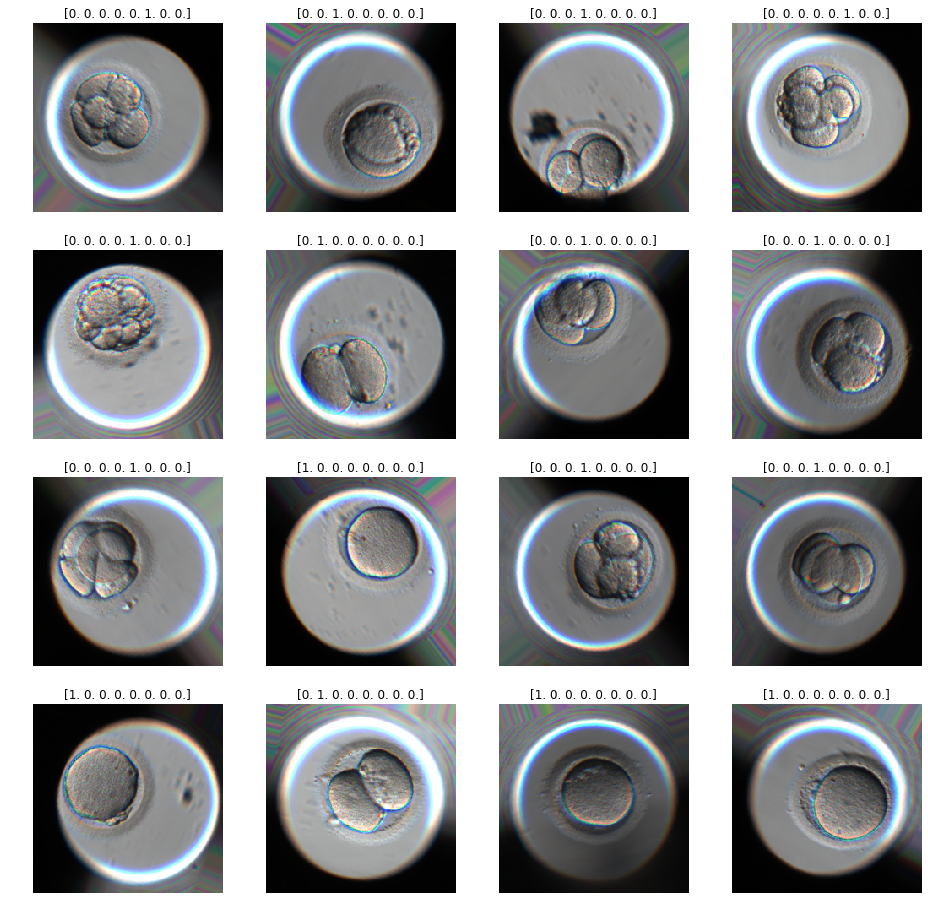

In [5]:
cols = 4
rows = 4

j = batch_size
fig = plt.figure(figsize=(4*cols, 4*rows))
for i in range(rows*cols):
    if j == batch_size:
        j = 0
        batch = next(trn_gen)
    a = fig.add_subplot(rows, cols, i+1)
    a.axis('off')
    a.set_title(batch[1][j])
    a.imshow(unprocess_input(batch[0][j])[:,:,disp_min:disp_max])
    j += 1

# Optional callbacks

In [6]:
tenosorboard = keras.callbacks.TensorBoard(
    log_dir=tensorboard_dir, histogram_freq=0,  
    write_graph=True, write_images=True)

In [7]:
from keras.callbacks import ModelCheckpoint

save_best_model = ModelCheckpoint(
    notebook+'_{epoch:02d}_{val_acc:.4f}.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=True, 
    mode='auto', 
    period=1
    )

In [8]:
callbacks = [tenosorboard, save_best_model]

## Create model EmbryoNet
The model is pre-trained, populated with weights from image net. In the first training passes we will only train the top fully connected and softmax layers. After that, we will unlock all weights and finetune the whole network.

In [9]:
from keras import applications
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.models import Model

# EmbryoNet is a copy of InceptionV3 from Keras. It is kept in a separate file so that the
# model can be modified and experimented with without changing Keras' source code.
base_model = EmbryoNet(
    weights=None,
    include_top=False, 
    input_shape=(image_size, image_size, len(focals))
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\jom2032\AppData\Local\conda\conda\envs\TensorFlow4-19\lib\site-packages\keras_applications\imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 7 input channels.
  str(input_shape[-1]) + ' input channels.')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 225, 225, 7)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 32) 2016        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
# Visualize model (optional)
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# If you are not training the model, you can skip the next sections down to where it says model.load_weights

## Train model

In [11]:
epochs = 75
lr = 1e-3
model.compile(optimizer=Nadam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

# Up to 4 workers provide a clear performance benefit with simple pre-processing
model.fit_generator(trn_gen, epochs=epochs, validation_data=val_gen, workers=6, callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/75
1024/1024 [==============================] - 595s 581ms/step - loss: 1.3074 - acc: 0.4559 - val_loss: 1.4558 - val_acc: 0.4655
Epoch 2/75
1024/1024 [==============================] - 594s 580ms/step - loss: 0.9860 - acc: 0.5873 - val_loss: 1.8881 - val_acc: 0.4538
Epoch 3/75
1024/1024 [==============================] - 597s 583ms/step - loss: 0.8943 - acc: 0.6305 - val_loss: 0.9476 - val_acc: 0.6106
Epoch 4/75
1024/1024 [==============================] - 593s 579ms/step - loss: 0.8358 - acc: 0.6564 - val_loss: 1.1994 - val_acc: 0.5314
Epoch 5/75
1024/1024 [==============================] - 593s 579ms/step - loss: 0.8037 - acc: 0.6698 - val_loss: 0.8412 - val_acc: 0.6467
Epoch 6/75
1024/1024 [==============================] - 600s 586ms/step - loss: 0.7655 - acc: 0.6913 - val_loss: 1.1227 - val_acc: 0.5596
Epoch 7/75
1024/1024 [==============================] - 591s 577ms/step - loss: 0.7329 - acc: 0.7055 - val_loss: 0.8707 - va

Epoch 58/75
1024/1024 [==============================] - 591s 577ms/step - loss: 0.4068 - acc: 0.8437 - val_loss: 0.5257 - val_acc: 0.8118
Epoch 59/75
1024/1024 [==============================] - 590s 576ms/step - loss: 0.4029 - acc: 0.8448 - val_loss: 0.5292 - val_acc: 0.8024
Epoch 60/75
1024/1024 [==============================] - 592s 578ms/step - loss: 0.4030 - acc: 0.8447 - val_loss: 0.5427 - val_acc: 0.7914
Epoch 61/75
1024/1024 [==============================] - 591s 577ms/step - loss: 0.3974 - acc: 0.8457 - val_loss: 0.5015 - val_acc: 0.8110
Epoch 62/75
1024/1024 [==============================] - 592s 578ms/step - loss: 0.3963 - acc: 0.8477 - val_loss: 0.4901 - val_acc: 0.8181
Epoch 63/75
1024/1024 [==============================] - 561s 547ms/step - loss: 0.3932 - acc: 0.8475 - val_loss: 0.5201 - val_acc: 0.8151
Epoch 64/75
1024/1024 [==============================] - 555s 542ms/step - loss: 0.3900 - acc: 0.8489 - val_loss: 0.5579 - val_acc: 0.8092
Epoch 65/75
1024/1024 [====

In [12]:
# Nadam is an adaptive optimizer, but accuracy is increased further by restarting at a lower learning rate
epochs = 25
lr = 1e-4
K.set_value(model.optimizer.lr, lr)

model.fit_generator(trn_gen, epochs=epochs, validation_data=val_gen, workers=6, callbacks=callbacks)

Epoch 1/25
1024/1024 [==============================] - 567s 554ms/step - loss: 0.3243 - acc: 0.8746 - val_loss: 0.4815 - val_acc: 0.8317
Epoch 2/25
1024/1024 [==============================] - 563s 550ms/step - loss: 0.3078 - acc: 0.8800 - val_loss: 0.4919 - val_acc: 0.8305
Epoch 3/25
1024/1024 [==============================] - 564s 550ms/step - loss: 0.3040 - acc: 0.8817 - val_loss: 0.4881 - val_acc: 0.8297
Epoch 4/25
1024/1024 [==============================] - 561s 548ms/step - loss: 0.2977 - acc: 0.8838 - val_loss: 0.4966 - val_acc: 0.8314
Epoch 5/25
1024/1024 [==============================] - 561s 548ms/step - loss: 0.2939 - acc: 0.8857 - val_loss: 0.5059 - val_acc: 0.8296
Epoch 6/25
1024/1024 [==============================] - 561s 547ms/step - loss: 0.2930 - acc: 0.8854 - val_loss: 0.5029 - val_acc: 0.8299
Epoch 7/25
1024/1024 [==============================] - 596s 582ms/step - loss: 0.2900 - acc: 0.8871 - val_loss: 0.5048 - val_acc: 0.8321
Epoch 8/25
1024/1024 [============

## Save model weights

In [13]:
model.save_weights(notebook+'.h5')

In [10]:
#model.load_weights(notebook+'.h5')

# Load weights from the epoch with highest accuracy
model.load_weights(notebook+'_07_0.8321.h5')


### Visualize some examples where prediction is incorrect

In [15]:
from math import ceil

batch_size = 100

max_data = 20

data = []

tst_data_gen = EmbryoDataGenerator(preprocessing_function=preprocess_input)
tst_gen = tst_data_gen.flow_from_embryo_directory(
    path+'valid', 
    target_size=(image_size,image_size), 
#    color_mode='grayscale',
    class_mode='categorical', 
    shuffle=True, 
    batch_size=batch_size,
    focals=focals)

all_labels = []
all_predictions = []
all_confidence = []

batch_count = ceil(tst_gen.samples / batch_size)
c = 0
for i in range(batch_count):
    sys.stdout.write("[" + "*"*i + "-"*(batch_count-i)+"]\r")
    #if max_data > 0 and max_data == len(data): break
    batch = next(tst_gen)
    y = model.predict(batch[0])
    for j in range(batch_size):
        if c == tst_gen.samples: break
        c += 1
        label = str(np.argmax(batch[1][j])+1)
        predicted = str(np.argmax(y[j])+1)
        all_labels.append(label)
        all_predictions.append(predicted)
        all_confidence.append(y[j])
        if label != predicted and len(data) < max_data:
            data.append([tst_gen.filenames[i*batch_size + j], label, predicted, batch[0][j], y[j]])
            #if max_data > 0 and max_data == len(data): break

print("[" + "*"*i +"] Found: " + str(len(data)) + " "*batch_count)

Found 14041 images belonging to 8 classes.
[********************************************************************************************************************************************] Found: 20                                                                                                                                             


In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion matrix:\n%s" % cm)

Confusion matrix:
[[1748    7    0    0    0    0    0    0]
 [   3 1727   13    8    2    1    1    0]
 [   0   42 1479  205   11   11    4    3]
 [   0   12  121 1496   73   36   12    5]
 [   0    1   16  109 1351  211   53   14]
 [   0    0    4   40  155 1203  273   80]
 [   0    0    3   10   26  194 1159  363]
 [   1    2    0    3    5   23  202 1520]]


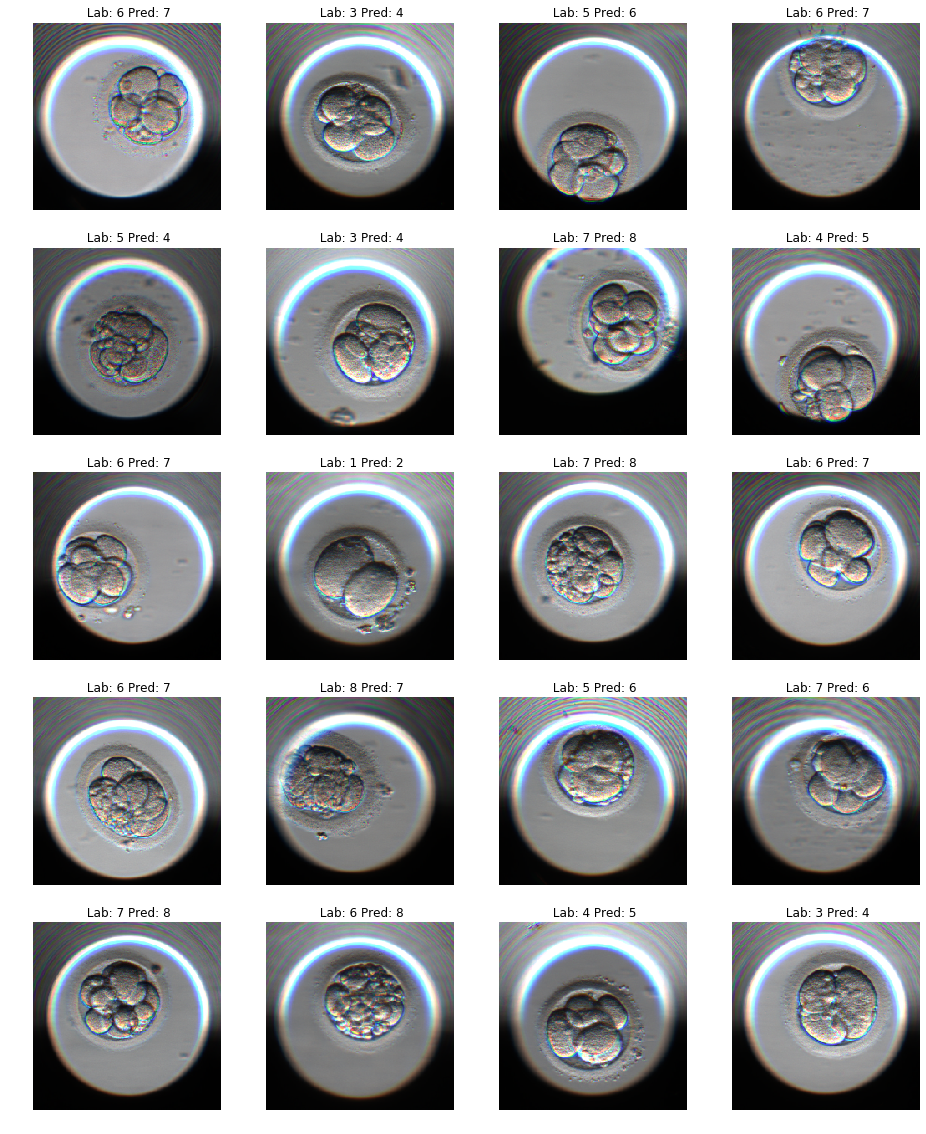

In [17]:
# Visalize a sample from mispredicted images
# sometimes it looks like it could be the label that is incorrect, but it is hard to tell if you are
# not an embryologist and have not seen the whole TLM. For example, large fragments can look very similar to blastomeres.
cols = 4
rows = ceil(len(data) / 4)

fig = plt.figure(figsize=(cols*4,rows*4))

for i in range(len(data)):
    a = fig.add_subplot(rows, cols, i+1)
    a.axis('off')
#    a.set_title(data[i][0] + ' Lab: ' + str(data[i][1]) + ' Pred: ' + str(data[i][2]))
    a.set_title(' Lab: ' + str(data[i][1]) + ' Pred: ' + str(data[i][2]))
    a.imshow(unprocess_input(data[i][3][:,:,disp_min:disp_max]), interpolation='nearest')


# Evaluate model using TLM data

In [18]:
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt
from math import ceil
import time

max_data = 200
eval_batch_size = 100

# Declare lists for storing data about each embryo
all_tlm_path = [] # list of string
all_tlm_labels = [] # List of lists, label/cell stage for every image, for each embryo
all_tlm_predictions = [] # List of lists
all_tlm_confidence = [] # List of lists
all_tlm_variance = [] # List of lists, image variance between every image, for each embryo

import os
basepath = 'C:/Research/Jonas/TLMTestData/'

ts = time.time()
   
for subdir in os.listdir(basepath):
    path = basepath+subdir

    tst_data_gen = EmbryoDataGenerator(preprocessing_function=preprocess_input)
    tst_gen = tst_data_gen.flow_from_embryo_directory(
        path, 
        target_size=(image_size,image_size), 
        class_mode='categorical', 
        shuffle=False, 
        batch_size=eval_batch_size,
        focals=focals)

    tlm_labels = []
    tlm_predictions = []
    tlm_confidence = []
    tlm_variance = []

    first_image = True
    
    batch_count = ceil(tst_gen.samples / eval_batch_size)
    c = 0
    for i in range(batch_count):
        sys.stdout.write("[" + "*"*i + "-"*(batch_count-i)+"]\r")
        batch = next(tst_gen)
        y = model.predict(batch[0])
        for j in range(eval_batch_size):
            if c == tst_gen.samples: break
            c += 1
            label = np.argmax(batch[1][j])+1
            predicted = np.argmax(y[j])+1
            this_image = batch[0][j]
            
            this_image = gaussian_filter(this_image, sigma=1)
            
            if first_image:
                variance = 0.0
            else:
                variance = (abs(prev_image - this_image) ** 2).mean()
            
            tlm_labels.append(label)
            tlm_predictions.append(predicted)
            tlm_confidence.append(y[j])
            tlm_variance.append(variance)
            
            prev_image = this_image
            first_image = False
        
    all_tlm_path.append(subdir)
    all_tlm_labels.append(tlm_labels)
    all_tlm_predictions.append(tlm_predictions)
    all_tlm_confidence.append(tlm_confidence)
    all_tlm_variance.append(tlm_variance)
    
    
    
print("[" + "*"*i +"] Found: " + str(len(all_tlm_path)) + " "*batch_count)

Found 214 images belonging to 8 classes.
Found 404 images belonging to 8 classes.
Found 331 images belonging to 8 classes.
Found 214 images belonging to 8 classes.
Found 447 images belonging to 8 classes.
Found 311 images belonging to 8 classes.
Found 240 images belonging to 8 classes.
Found 398 images belonging to 8 classes.
Found 277 images belonging to 8 classes.
Found 323 images belonging to 8 classes.
Found 158 images belonging to 8 classes.
Found 410 images belonging to 8 classes.
Found 454 images belonging to 8 classes.
Found 416 images belonging to 8 classes.
Found 189 images belonging to 8 classes.
Found 343 images belonging to 8 classes.
Found 369 images belonging to 8 classes.
Found 396 images belonging to 8 classes.
Found 378 images belonging to 8 classes.
Found 417 images belonging to 8 classes.
Found 260 images belonging to 8 classes.
Found 357 images belonging to 8 classes.
Found 413 images belonging to 8 classes.
Found 239 images belonging to 8 classes.
Found 209 images

In [19]:
# Sometimes the embryo dish is moved, using median filter will eliminate large single frame changes.
# This was uncommented for mouse dataset because because there are no missing frames, 
# and cell stage transitions often happen in a single frame, which is not the case for human embryos.
for i, tlm_variance in enumerate(all_tlm_variance):
    all_tlm_variance[i] = medfilt(tlm_variance, 3)


# Find median predictions for use by human TLM analysis

In [20]:
all_tlm_median_predictions = []

for predictions in all_tlm_predictions:
    median_predictions = medfilt(predictions, 3)
    all_tlm_median_predictions.append(median_predictions)

In [21]:
from sklearn.metrics import confusion_matrix

# Flatten lists
all_labels = [item for sublist in all_tlm_labels for item in sublist]
all_predictions = [item for sublist in all_tlm_predictions for item in sublist]
all_median_predictions = [item for sublist in all_tlm_median_predictions for item in sublist]
all_confidence = [item[np.argmax(item)] for sublist in all_tlm_confidence for item in sublist]

# Print confusion matrix for predictions
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion matrix for predictions:\n%s" % cm)

# Print confuction matrix for median predictions
cm = confusion_matrix(all_labels, all_median_predictions)
print("Confusion matrix for median predictions:\n%s" % cm)

Confusion matrix for predictions:
[[10528   241     0     0     0     0     0     0]
 [    3  5601   195    69     0     1     0     7]
 [    0    29   331   215     4     2     1     0]
 [    0     0    39  6000   252     5     0     0]
 [    0     1     3    22   538    93    10     0]
 [    0     0     1     6    38   524   115    10]
 [    0     0     0     0     2   106  1008   290]
 [  112    33     0    10     6    38   331  7329]]
Confusion matrix for median predictions:
[[10527   242     0     0     0     0     0     0]
 [    3  5616   178    72     0     2     0     5]
 [    0    25   336   217     4     0     0     0]
 [    0     0    28  6020   244     4     0     0]
 [    0     0     4    15   551    87    10     0]
 [    0     0     0     3    38   533   115     5]
 [    0     0     0     0     1    97  1027   281]
 [  110    32     0     9     3    33   322  7350]]


# Plot TLM transition cost curves (edge-penalty based on image variance)
Also, computes the cell stage transition costs for each frame.

C:\Users\jom2032\AppData\Local\conda\conda\envs\TensorFlow4-19\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


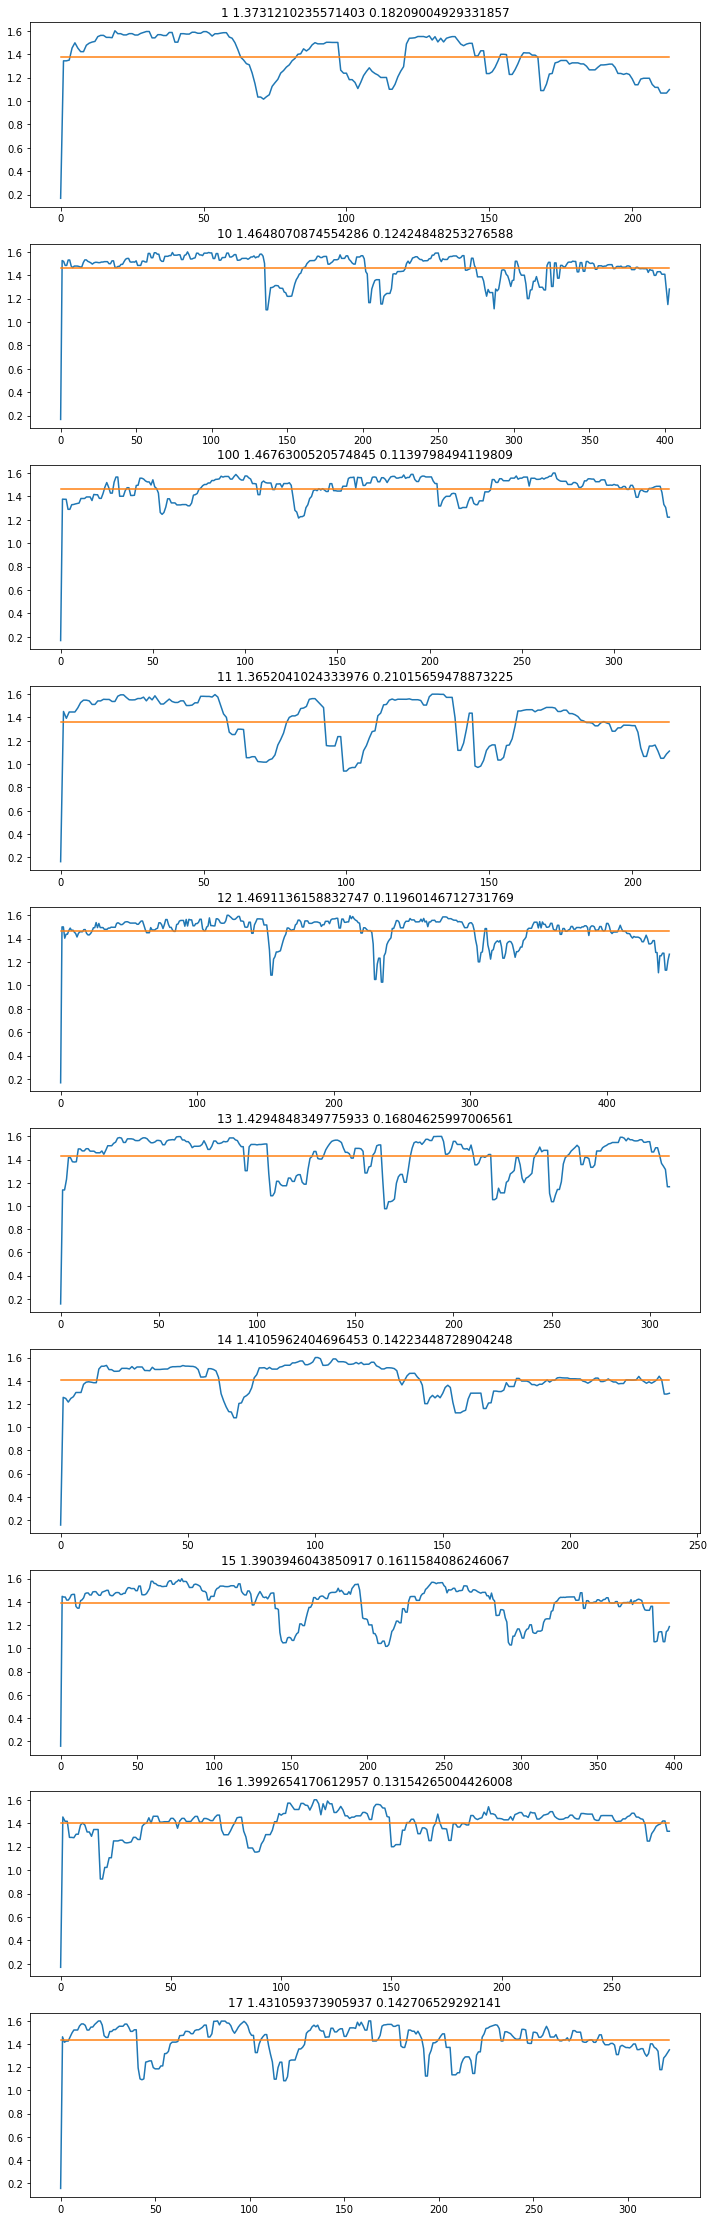

In [22]:
cols = 1
#rows = 100
rows = 10 # Only plot 10 examples (to reduce results file size)

# Declare lists for storing data about each embryo
all_tlm_transition_cost = [] # list of string

fig = plt.figure(figsize=(12*cols, 4*rows))
for i, (tlm_path, tlm_variance) in enumerate(zip(all_tlm_path, all_tlm_variance)):

    tlm_transition_cost = tlm_variance.copy()
    tlm_transition_cost = -np.log(tlm_transition_cost) # Use log to normalize tall peaks
    tlm_transition_cost[np.isinf(tlm_transition_cost)]=1 # log(0) returns inf - now safe to ignore divide by zero warning
    tlm_transition_cost *= 1.6/tlm_transition_cost.max() # Normalize penalty
    
    if i < rows:
        a = fig.add_subplot(rows, cols, i+1)
        a.plot(tlm_transition_cost)
    
        diff_mean = tlm_transition_cost.mean()
        t = np.repeat(diff_mean, len(tlm_transition_cost))
        a.plot(t)
        a.set_title(tlm_path + " " + str(diff_mean) + " " + str(tlm_transition_cost.std()))
    
    all_tlm_transition_cost.append(tlm_transition_cost)

# Global optimization method for predicting cell stages
TLM optimization using the forward-backward dynamic programming algorithm

In [23]:
# Recursive utility function for the forward pass of the algorithm. A recursive function may not
# be the most optimal for speed and memory usage, but it performs well enough and is easy to read.
def GetConfidenceSum(frames, transition_cost, confidence_sum, frame_no, cell_stage):
    # Lookup return value in dynamic programming table
    ret_val = confidence_sum[frame_no, cell_stage]
    
    if ret_val == .0: 
        # ret_val needs to be computed
        
        if frame_no == 0: 
            # End recursion - return probability for the first frame            
            ret_val = frames[0][cell_stage]
        else:
            # Compute return value
            # Find optimal path from previous frame with lesser or equal cell stage
            for prev_cell_stage in range(cell_stage+1): 
                new_val = GetConfidenceSum(frames, transition_cost, confidence_sum, frame_no-1, prev_cell_stage)
                
                # Penalize probability of cell stage transition based on image variance (edge-penalty)
                if cell_stage != prev_cell_stage: 
                    new_val -= transition_cost[frame_no]
                    
                # Use the optimal value    
                if new_val > ret_val:
                    ret_val = new_val
            
            # Add cost for current frame
            ret_val += frames[frame_no][cell_stage]
            
        # Store this result in table so we don't need to compute it again
        confidence_sum[frame_no, cell_stage] = ret_val
        
    return ret_val


all_global_tlm_predictions = []

for tlm_confidence, tlm_transition_cost in zip(all_tlm_confidence, all_tlm_transition_cost):
    
# Get number of frames for current embryo
    frame_count = len(tlm_confidence)

# Get number of cell stages (assume there is at least one frame)
    cell_stages = len(tlm_confidence[0]) 

# Allocate table for dynamic programming data/cache
    confidence_sum = np.zeros((frame_count, cell_stages)) # Allocate empty array for computing confidence sums

# Forward pass
    for j in range(cell_stages):
        GetConfidenceSum(tlm_confidence, tlm_transition_cost, confidence_sum, frame_count - 1, j)

# Backward pass
    prev_prediction = cell_stages # initialize previous prediction to a fictive prediction of max cell count
    predictions = np.empty((frame_count)) # allocate empty array to contain final predictions
    for i in range(frame_count-1, -1, -1):
        j = np.argmax(confidence_sum[i][0:prev_prediction])+1
            
        prev_prediction = j # Compute previous prediction with a constraint: cannot be more cells than previous prediction
        predictions[i] = prev_prediction
    
    all_global_tlm_predictions.append(predictions)

# Transform TLM data into aggregates and timings for labels and predictions
Timings are used further down to compute accuracy within N frames

In [24]:
# Allocate variables to store aggregate of labels and predictions, how many labels and predictions of each cell stage
all_agg_labels = []
all_agg_predictions = []

# Allocate variable to store timings of labels and predictions
all_timings_labels = []
all_timings_predictions = []


# Aggregate labels and predictions
for i, (tlm_labels, global_tlm_predictions) in enumerate(zip(all_tlm_labels, all_global_tlm_predictions)):
    agg_labels = np.zeros(num_classes)
    agg_predictions = np.zeros(num_classes)
    for l, p in zip(tlm_labels, global_tlm_predictions):
        agg_labels[int(l)-1] += 1
        agg_predictions[int(p)-1] += 1
    print("Embryo %d aggregate %s %s "%(i,agg_labels,agg_predictions))
    all_agg_labels.append(agg_labels)
    all_agg_predictions.append(agg_predictions)
    
    timing_labels = np.zeros(num_classes)
    timing_predictions = np.zeros(num_classes)
    l = p = 0
    for j, (tl, tp) in enumerate(zip(agg_labels, agg_predictions)):
        timing_labels[j] = l
        timing_predictions[j] = p
        l += int(tl)
        p += int(tp)

    print("Embryo %d timings %s %s "%(i,timing_labels,timing_predictions))
    all_timings_labels.append(timing_labels)
    all_timings_predictions.append(timing_predictions)

Embryo 0 aggregate [70. 33. 14. 33.  9.  9.  1. 45.] [70. 34. 13. 36. 17.  0.  0. 44.] 
Embryo 0 timings [  0.  70. 103. 117. 150. 159. 168. 169.] [  0.  70. 104. 117. 153. 170. 170. 170.] 
Embryo 1 aggregate [141.  69.   5.  67.   4.   4.  24.  90.] [139.  66.   9.  68.   6.   0.  24.  92.] 
Embryo 1 timings [  0. 141. 210. 215. 282. 286. 290. 314.] [  0. 139. 205. 214. 282. 288. 288. 312.] 
Embryo 2 aggregate [ 59.  70.   4.  73.  11.   4.   5. 105.] [ 56.  73.   3.  74.  11.   5.   5. 104.] 
Embryo 2 timings [  0.  59. 129. 133. 206. 217. 221. 226.] [  0.  56. 129. 132. 206. 217. 222. 227.] 
Embryo 3 aggregate [66. 33.  2. 44.  2.  6.  3. 58.] [67. 33.  0. 46.  5.  4.  0. 59.] 
Embryo 3 timings [  0.  66.  99. 101. 145. 147. 153. 156.] [  0.  67. 100. 100. 146. 151. 155. 155.] 
Embryo 4 aggregate [158.  72.   9.  70.   8.   8.   9. 113.] [156.  75.   5.  72.   7.  10.   8. 114.] 
Embryo 4 timings [  0. 158. 230. 239. 309. 317. 325. 334.] [  0. 156. 231. 236. 308. 315. 325. 333.] 
Em

# Compute accuracy within N frames
It has been noted that accuracy within N frames is not always 100% because of random elements during training of the model.

In [25]:
n = len(all_timings_labels)

print("Accuracy within N frames:")

for frames in range(10):
    correct = np.zeros(num_classes)
    
    for timing_labels, timing_predictions in zip(all_timings_labels, all_timings_predictions):
        correct += np.abs(timing_labels-timing_predictions)<=frames
        
    print(str(frames)+": "+str(correct/n)+" "+str(np.mean(correct)))

Accuracy within N frames:
0: [1.   0.2  0.47 0.27 0.25 0.27 0.35 0.18] 37.375
1: [1.   0.6  0.82 0.65 0.74 0.69 0.64 0.5 ] 70.5
2: [1.   0.81 0.93 0.8  0.89 0.86 0.76 0.64] 83.625
3: [1.   0.9  0.96 0.87 0.92 0.89 0.84 0.75] 89.125
4: [1.   0.92 0.96 0.91 0.93 0.92 0.87 0.85] 92.0
5: [1.   0.97 0.97 0.96 0.95 0.95 0.89 0.86] 94.375
6: [1.   0.98 0.98 0.97 0.96 0.96 0.9  0.9 ] 95.625
7: [1.   0.99 0.98 0.98 0.97 0.98 0.94 0.91] 96.875
8: [1.   1.   0.98 0.98 0.97 0.98 0.95 0.91] 97.125
9: [1.   1.   0.98 0.98 0.97 0.98 0.97 0.91] 97.375


In [26]:
from sklearn.metrics import confusion_matrix

# Flatten lists
all_labels = [item for sublist in all_tlm_labels for item in sublist]
all_predictions = [item for sublist in all_tlm_predictions for item in sublist]
all_median_predictions = [item for sublist in all_tlm_median_predictions for item in sublist]
all_global_predictions = [item for sublist in all_global_tlm_predictions for item in sublist]
all_peak_confidence = [item[np.argmax(item)] for sublist in all_tlm_confidence for item in sublist]
all_confidence = [item for sublist in all_tlm_confidence for item in sublist]

# Print confuction matrix for predictions (should match previous confusion matrix)
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion matrix for predictions:\n%s" % cm)

# Print confuction matrix for median predictions
cm = confusion_matrix(all_labels, all_median_predictions)
print("Confusion matrix for median predictions:\n%s" % cm)

# Print confuction matrix for global predictions
cm = confusion_matrix(all_labels, all_global_predictions)
print("Confusion matrix for global predictions:\n%s" % cm)

Confusion matrix for predictions:
[[10528   241     0     0     0     0     0     0]
 [    3  5601   195    69     0     1     0     7]
 [    0    29   331   215     4     2     1     0]
 [    0     0    39  6000   252     5     0     0]
 [    0     1     3    22   538    93    10     0]
 [    0     0     1     6    38   524   115    10]
 [    0     0     0     0     2   106  1008   290]
 [  112    33     0    10     6    38   331  7329]]
Confusion matrix for median predictions:
[[10527   242     0     0     0     0     0     0]
 [    3  5616   178    72     0     2     0     5]
 [    0    25   336   217     4     0     0     0]
 [    0     0    28  6020   244     4     0     0]
 [    0     0     4    15   551    87    10     0]
 [    0     0     0     3    38   533   115     5]
 [    0     0     0     0     1    97  1027   281]
 [  110    32     0     9     3    33   322  7350]]
Confusion matrix for global predictions:
[[10616   153     0     0     0     0     0     0]
 [   10  5808  

# Plot ROC curves

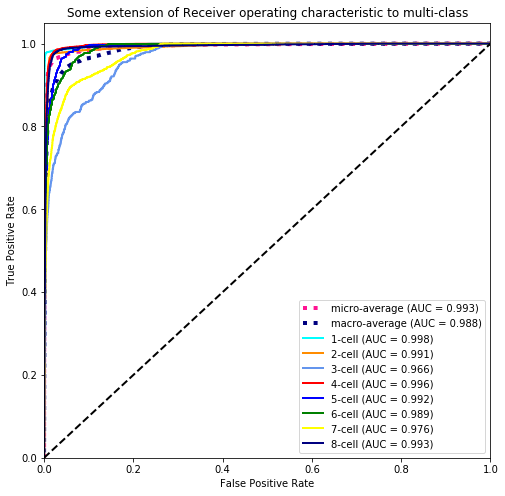

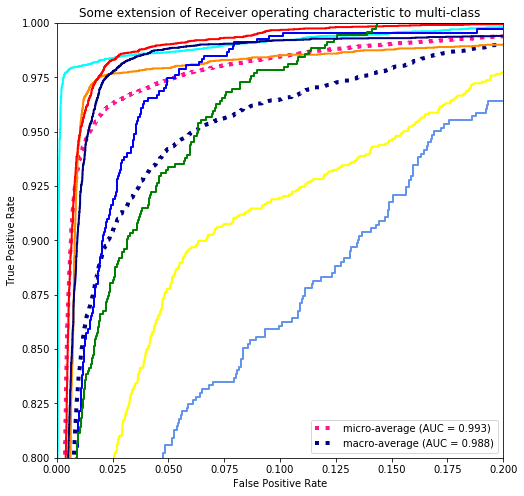

In [27]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

confidence = np.asarray(all_confidence)
labels = np.zeros((len(all_labels),8))
labels[np.arange(len(all_labels)), np.asarray(all_labels)-1] = 1

lw = 2

n_classes = 8

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], confidence[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(labels.ravel(), confidence.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (AUC = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (AUC = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'yellow', 'navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0}-cell (AUC = {1:0.3f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2, figsize=(8, 8))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (AUC = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (AUC = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'yellow', 'navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw)
#             label='{0}-cell (AUC = {1:0.2f})'
#             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()